# Building a classifier for clothing articles

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load FashionMNIST Dataset

In [ ]:
train_csv = pd.read_csv("../input/fashion-mnist_train.csv")
test_csv = pd.read_csv("../input/fashion-mnist_test.csv")

In [ ]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

Create method for label mapping

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [ ]:
#iterating into the data
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape) #shape of all 100 images
print(images[1].shape) #shape of one image
print(labels[1].item()) #label number

torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
0


<class 'torch.Tensor'>
(1, 28, 28)
(28, 28, 1)


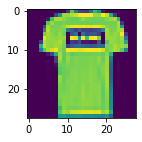

In [ ]:
#taking the first image from batch of 100 images

img = images[1]
print(type(img))

#convert the tensor to numpy for displaying the image
npimg = img.numpy()
print(npimg.shape)

#To display the image, shape of the image should be height * width * channels
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)
np.squeeze(npimg).shape

plt.figure(figsize = (2,2))
plt.imshow(np.squeeze(npimg))
plt.show()

In [ ]:
len(train_set)

60000

9


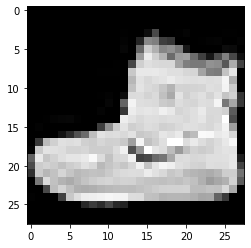

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Visualize some data images and labels


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

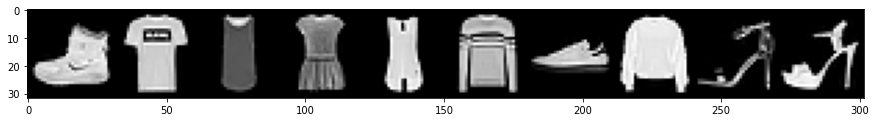

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

**Build the Model**

Creating a model class (FashionCNN)
It inherits nn.Module class that is a super class for all the neural networks in Pytorch.

It consists of the following layers:

Two Sequential layers each consisting of:


*   Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
*   Batch Normalization layer.

*   Acitvation function: ReLU.

*   Max Pooling layer with kernel size of 2 * 2 and stride 2.

*   Flatten out the output for fcn.

*   2 Fully connected layer with different in/out features.

*   1 Dropout layer that has class probability p = 0.25.

All the functionaltiy is given in forward method that defines the forward pass of CNN.

The input image is changing in a following way:

**First Convulation layer** : input: 28 * 28 * 3, output: 28 * 28 * 32

**First Max Pooling layer** : input: 28 * 28 * 32, output: 14 * 14 * 32

**Second Conv layer** : input : 14 * 14 * 32, output: 12 * 12 * 64

**Second Max Pooling layer** : 12 * 12 * 64, output: 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [10]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [ ]:
!pip install flopth

In [ ]:
# import flopth to calculate FLOPs per layer (dropout is not taken into consideration for this)
from flopth import flopth

# declare Model object
my_model = FashionCNN()

# Use input size
flops, params = flopth(my_model, in_size=((1, 28, 28),), show_detail=True)
print(flops, params)

Op Dropout2d is not supported at now.
Op Dropout2d is not supported at now.
Op Dropout2d is not supported at now.
+---------------+---------------+------------+-------------+----------+------------------+---------------------------------------------------+----------+-----------------+-------------------------------+
| module_name   | module_type   | in_shape   | out_shape   | params   | params_percent   | params_percent_vis                                | flops    | flops_percent   | flops_percent_vis             |
+===============+===============+============+=============+==========+==================+===================================================+==========+=================+===============================+
| layer1.0      | Conv2d        | (1,28,28)  | (32,28,28)  | 320.0    | 0.022727%        |                                                   | 250.88K  | 5.65055%        | ##                            |
+---------------+---------------+------------+-------------+----------

In [60]:
#Get receptive field per layer
import torch.nn.functional as F
from pytorch_receptive_field.torch_receptive_field import receptive_field, receptive_field_for_unit
my_model = FashionCNN()
receptive_field_dict = receptive_field(my_model, (1, 28, 28))
receptive_field_for_unit(receptive_field_dict, "2", (1,1))

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0               [28, 28]        0.5        1.0             1.0 
        1               [28, 28]        0.5        1.0             3.0 
        2               [28, 28]        0.5        1.0             3.0 
        3               [28, 28]        0.5        1.0             3.0 
        4               [14, 14]        1.0        2.0             4.0 
        5               [12, 12]        3.0        2.0             8.0 
        6               [12, 12]        3.0        2.0             8.0 
        7               [12, 12]        3.0        2.0             8.0 
        8                 [6, 6]        4.0        4.0            10.0 
Receptive field size for layer 2, unit_position (1, 1),  is 
 [(0, 3.0), (0, 3.0)]


[(0, 3.0), (0, 3.0)]

In [ ]:
!pip install thop

In [8]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from torchsummary import summary
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(summary(model,(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                   [-1, 10]           6,010
Total params: 1,408,018
Trainable params: 1,408,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5451227426528931, Accuracy: 87.12000274658203%
Iteration: 1000, Loss: 0.32656821608543396, Accuracy: 87.4800033569336%
Iteration: 1500, Loss: 0.30666908621788025, Accuracy: 88.3499984741211%
Iteration: 2000, Loss: 0.2165915071964264, Accuracy: 88.9800033569336%
Iteration: 2500, Loss: 0.12569573521614075, Accuracy: 89.3499984741211%
Iteration: 3000, Loss: 0.1914568841457367, Accuracy: 90.29000091552734%


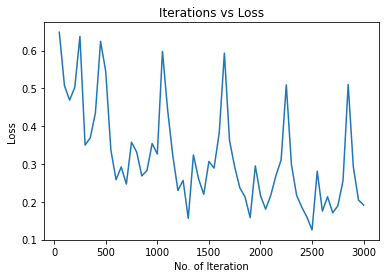

In [ ]:
#Loss Plot
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

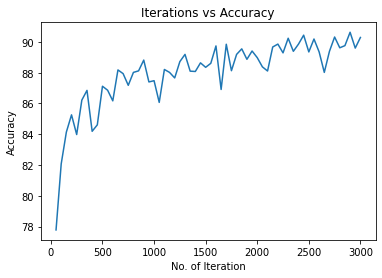

In [ ]:
#Accuracy Plot
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 92.60%
Accuracy of Trouser: 98.70%
Accuracy of Pullover: 88.40%
Accuracy of Dress: 91.60%
Accuracy of Coat: 76.10%
Accuracy of Sandal: 96.50%
Accuracy of Shirt: 66.20%
Accuracy of Sneaker: 96.00%
Accuracy of Bag: 98.70%
Accuracy of Ankle Boot: 97.70%


In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics

cm = confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     60000
           1       0.97      0.98      0.98     60000
           2       0.83      0.81      0.82     60000
           3       0.87      0.89      0.88     60000
           4       0.80      0.81      0.81     60000
           5       0.96      0.97      0.97     60000
           6       0.69      0.64      0.67     60000
           7       0.93      0.94      0.94     60000
           8       0.96      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000




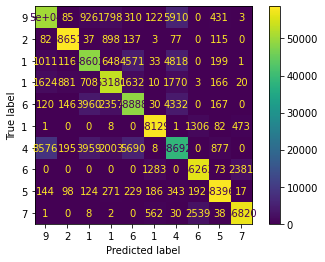

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_l)
disp.plot()
plt.show()

In [ ]:
!pip install scikit-plot

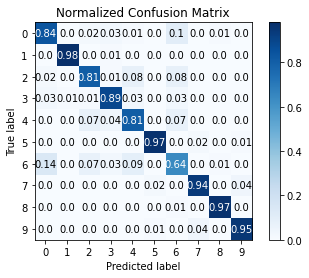

In [ ]:

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(labels_l,predictions_l, normalize=True)

In [ ]:
# create a quantized model instance
model_int8 = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

In [ ]:
model_int8.to(device)

#Using Cross Entropy Loss and Adam optimizer

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model_int8.parameters(), lr=learning_rate)
print(model_int8)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): DynamicQuantizedLinear(in_features=2304, out_features=600, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): DynamicQuantizedLinear(in_features=600, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list_u8 = []
iteration_list_u8 = []
accuracy_list_u8 = []

# Lists for knowing classwise accuracy
predictions_list_u8 = []
labels_list_u8 = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model_int8(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list_u8.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy_u8 = correct * 100 / total
            # loss_list.append(loss.data)
            iteration_list_u8.append(count)
            accuracy_list_u8.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Accuracy: {}%".format(count, accuracy_u8))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 0, Accuracy: 90.16999816894531%
Iteration: 0, Accuracy: 90.16999816894531%


KeyboardInterrupt: ignored

In [ ]:
!git clone https://github.com/Fangyh09/pytorch-receptive-field.git